# Rock, Paper & Scissors with TensorFlow Hub - TFLite

## Set up library versions for TF2

In [1]:
# !pip uninstall tensorflow --yes
!pip install -U --pre -q tensorflow-gpu==2.0.0-beta1
# !pip install -U --pre -q tensorflow-gpu==2.0.0
#!pip install -U --pre -q tf-nightly-gpu-2.0-preview==2.0.0.dev20190715
# Last tested version: 2.0.0-dev20190704

     |████████████████████████████████| 348.9MB 49kB/s 
     |████████████████████████████████| 501kB 34.1MB/s 
     |████████████████████████████████| 3.1MB 38.8MB/s 


In [2]:
!pip install -U --pre -q tf-estimator-nightly==1.14.0.dev2019071001

ERROR: tensorflow-gpu 2.0.0b1 has requirement tf-estimator-nightly<1.14.0.dev2019060502,>=1.14.0.dev2019060501, but you'll have tf-estimator-nightly 1.14.0.dev2019071001 which is incompatible.


In [0]:
# !pip uninstall tensorflow-hub --yes
!pip install -U --pre -q tf-hub-nightly==0.6.0.dev201907150002
# Last tested version: Hub version:  0.6.0.dev201907160002

In [2]:
from __future__ import absolute_import, division, print_function

import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.7.0
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [5]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

# Go to the TensorFlow Dataset's website and search for the Rock, Paper, Scissors dataset and load it here
splits, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True, split = splits )
    
# Save the dataset splits in a tuple
(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/1.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label



Now shuffle and batch the data


In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [0]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect a batch

In [9]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = True #@param {type:"boolean"}

In [11]:
# Build the model with a TFHub KerasLayer and attach a classification head to it
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE,
                   input_shape=IMAGE_SIZE + (3, ), 
                   output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


## Training the model

In [0]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
EPOCHS = 3
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


73/73 [==============================] - 106s 1s/step - loss: 0.2186 - accuracy: 0.9477 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
73/73 [==============================] - 60s 824ms/step - loss: 0.0850 - accuracy: 1.0000 - val_loss: 0.1159 - val_accuracy: 0.9893
Epoch 3/3
73/73 [==============================] - 60s 822ms/step - loss: 0.0839 - accuracy: 1.0000 - val_loss: 0.0844 - val_accuracy: 1.0000


## Export the model

In [0]:
RPS_SAVED_MODEL = "exp_saved_model"

Export the SavedModel

In [15]:
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model
# YOUR CODE HERE
tf.saved_model.save(model, RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


Here you can verify the default signature of your exported SavedModel

In [16]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [18]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert with TFLiteConverter

In [20]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()
    
with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)


  

INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


Run the following cells to check whether your TFLite model is working using the Python Interpreter

In [0]:
#@title Loading the converted TFLite model...
# Load TFLite model and allocate tensors.
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [22]:
#@title Testing on random test examples...
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

10it [00:01,  5.50it/s]


In [0]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



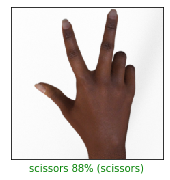

In [24]:
#@title Visualize the outputs { run: "auto" }
index = 9 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Download the model

In [0]:
from google.colab import files

files.download('converted_model.tflite')


with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))
  
files.download('labels.txt')

# Prepare the test images for download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [0]:
!mkdir -p test_images

In [0]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [29]:
!ls test_images

paper_10.jpg  paper_44.jpg  rock_1.jpg	 rock_41.jpg	  scissors_32.jpg
paper_14.jpg  paper_46.jpg  rock_22.jpg  rock_45.jpg	  scissors_33.jpg
paper_19.jpg  paper_49.jpg  rock_23.jpg  rock_47.jpg	  scissors_35.jpg
paper_20.jpg  paper_6.jpg   rock_24.jpg  scissors_11.jpg  scissors_37.jpg
paper_25.jpg  paper_8.jpg   rock_27.jpg  scissors_13.jpg  scissors_43.jpg
paper_31.jpg  rock_0.jpg    rock_28.jpg  scissors_16.jpg  scissors_48.jpg
paper_38.jpg  rock_12.jpg   rock_30.jpg  scissors_21.jpg  scissors_4.jpg
paper_39.jpg  rock_15.jpg   rock_34.jpg  scissors_26.jpg  scissors_5.jpg
paper_40.jpg  rock_17.jpg   rock_36.jpg  scissors_29.jpg  scissors_7.jpg
paper_42.jpg  rock_18.jpg   rock_3.jpg	 scissors_2.jpg   scissors_9.jpg


In [0]:
!zip -qq rps_test_images.zip -r test_images/

In [0]:
files.download('rps_test_images.zip')